# GENERADOR DE DATASET- GASTOS PERSONALES

Como es de conocimeinto publico los datos de ingresos y gastos de una persona son información sensible y a falta de un dataset completo de gastos e ingresos de una persona se desarrolla este proyecto para las practicas de ciencia de datos.

## PASO 1: Generar proyección del Historial de remuneracion minima vital 
 
 trabajamos esta fuente primero
 **historial_salario_minimo.csv**

fuente (BCR): https://estadisticas.bcrp.gob.pe/estadisticas/series/mensuales/resultados/PN02124PM/html/1970-1/2025-9/

In [2]:
# Instalación de librerías necesarias
%pip install pandas numpy matplotlib seaborn scikit-learn statsmodels prophet tabulate

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from datetime import timedelta, date, datetime
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

In [4]:
# --- 1. Cargar el archivo y configurar ---

# Nombre de los archivos
archivo_entrada = 'historial_salario_minimo.csv'
archivo_salida = 'proyeccion_salario_minimo.csv'

In [7]:
# Ruta absoluta del directorio donde se encuentra este script/notebook
directorio_actual = os.getcwd()

In [9]:
# Ruta completa del archivo de entrada
ruta_entrada = os.path.join(directorio_actual, archivo_entrada)

In [18]:
try:
    df = pd.read_csv(ruta_entrada)
except FileNotFoundError:
    print(f"Error: El archivo '{archivo_entrada}' no se encontró en el directorio: {directorio_actual}")
    exit()

# --- 2. Preprocesamiento y Creación de la Serie Temporal ---

# Función para convertir 'Ene91' a '1991-01-01'
def parse_date(date_str):
    mes = date_str[:3]
    anio = date_str[3:]
    meses_map = {
        'Ene': 1, 'Feb': 2, 'Mar': 3, 'Abr': 4, 'May': 5, 'Jun': 6,
        'Jul': 7, 'Ago': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dic': 12
    }
    # Completar el año (ej. '91' a '1991', '25' a '2025')
    if len(anio) == 2:
        if int(anio) > 50:
            anio = '19' + anio
        else:
            anio = '20' + anio
    return datetime(int(anio), meses_map[mes], 1)

# Aplicar la función de conversión de fecha
df['Fecha_dt'] = df['Fecha'].apply(parse_date)

# Establecer la fecha de inicio para el cálculo de los días (Ene91)
fecha_inicio = df['Fecha_dt'].min()

# Calcular el número de meses desde el inicio (característica temporal)
# Esto es X para el modelo de regresión
df['Mes_Index'] = (df['Fecha_dt'].dt.to_period('M') - fecha_inicio.to_period('M')).apply(lambda x: x.n)
df['Salario_minimo'] = pd.to_numeric(df['Salario_minimo'], errors='coerce')


# --- 3. Entrenamiento del Modelo (Regresión Polinomial de Grado 2) ---

X_train = df[['Mes_Index']].values
y_train = df['Salario_minimo'].values

# Crear características polinomiales (grado 2)
# Grado 2 es Mes_Index y (Mes_Index)^2
poly_features = PolynomialFeatures(degree=2)
X_poly_train = poly_features.fit_transform(X_train)

# Entrenar el modelo de Regresión Lineal con las características polinomiales
model = LinearRegression()
model.fit(X_poly_train, y_train)

# --- 4. Preparación de la Proyección (hasta Dic-2035) ---

# Calcular el índice del último mes en los datos originales (Dic2025)
ultimo_indice = df['Mes_Index'].max()

# Definir la fecha de fin de la proyección (Dic-2035)
fecha_fin_proyeccion = datetime(2035, 12, 1)

# Calcular el índice del último mes de la proyección
# LÍNEA CORREGIDA: Se usa pd.Timestamp() para convertir el objeto datetime estándar
indice_fin_proyeccion = (pd.Timestamp(fecha_fin_proyeccion).to_period('M') - fecha_inicio.to_period('M')).n

# Crear una serie de índices de meses para la proyección (desde el inicio hasta Dic-2035)
indices_proyeccion = np.arange(0, indice_fin_proyeccion + 1).reshape(-1, 1)

# Crear las características polinomiales para la proyección
X_proyeccion = poly_features.transform(indices_proyeccion)

# Realizar la proyección
proyecciones = model.predict(X_proyeccion)

# --- 5. Creación del DataFrame de Proyección y Exportación ---

# Crear el DataFrame de resultados
df_proyeccion = pd.DataFrame()
df_proyeccion['Mes_Index'] = indices_proyeccion.flatten()

# Crear la columna de Fecha en formato datetime
df_proyeccion['Fecha_dt'] = df_proyeccion['Mes_Index'].apply(
    lambda i: fecha_inicio + pd.DateOffset(months=i)
)

# Formatear la columna 'Fecha' como 'Ene91', 'Feb91', etc.
def format_date_output(dt):
    mes_abr = dt.strftime('%b')[:3]
    anio_dos_digitos = dt.strftime('%y')
    return f"{mes_abr.capitalize()}{anio_dos_digitos}"

df_proyeccion['Fecha'] = df_proyeccion['Fecha_dt'].apply(format_date_output)

# Asignar los salarios proyectados
df_proyeccion['Salario_minimo_proyectado'] = np.maximum(proyecciones, df['Salario_minimo'].min()).round(2)

# Determinar si el valor es un historial o una proyección
df_proyeccion['Tipo_de_valor'] = np.where(
    df_proyeccion['Mes_Index'] <= ultimo_indice, 
    'Historial', 
    'Proyección'
)

# Filtrar para obtener solo las columnas deseadas para la exportación
df_final = df_proyeccion[['Fecha', 'Salario_minimo_proyectado', 'Tipo_de_valor']].rename(columns={'Salario_minimo_proyectado': 'Salario_minimo'})

# Guardar el nuevo archivo CSV
ruta_salida = os.path.join(directorio_actual, archivo_salida)
df_final.to_csv(ruta_salida, index=False)

print(f"✅ ¡Proceso completado!")
print(f"Se ha creado el archivo de proyección: {archivo_salida}")
print(f"Ubicación: {ruta_salida}")
print("\n--- Vista previa de los datos proyectados (últimas filas) ---")
print(df_final[df_final['Tipo_de_valor'] == 'Proyección'].tail())

✅ ¡Proceso completado!
Se ha creado el archivo de proyección: proyeccion_salario_minimo.csv
Ubicación: /home/gandalf/Projects/notebooks/gastos_personales_dataset_generator/proyeccion_salario_minimo.csv

--- Vista previa de los datos proyectados (últimas filas) ---
     Fecha  Salario_minimo Tipo_de_valor
535  Aug35         1382.71    Proyección
536  Sep35         1385.17    Proyección
537  Oct35         1387.62    Proyección
538  Nov35         1390.08    Proyección
539  Dec35         1392.54    Proyección



--- Generando Gráfica de Proyección ---


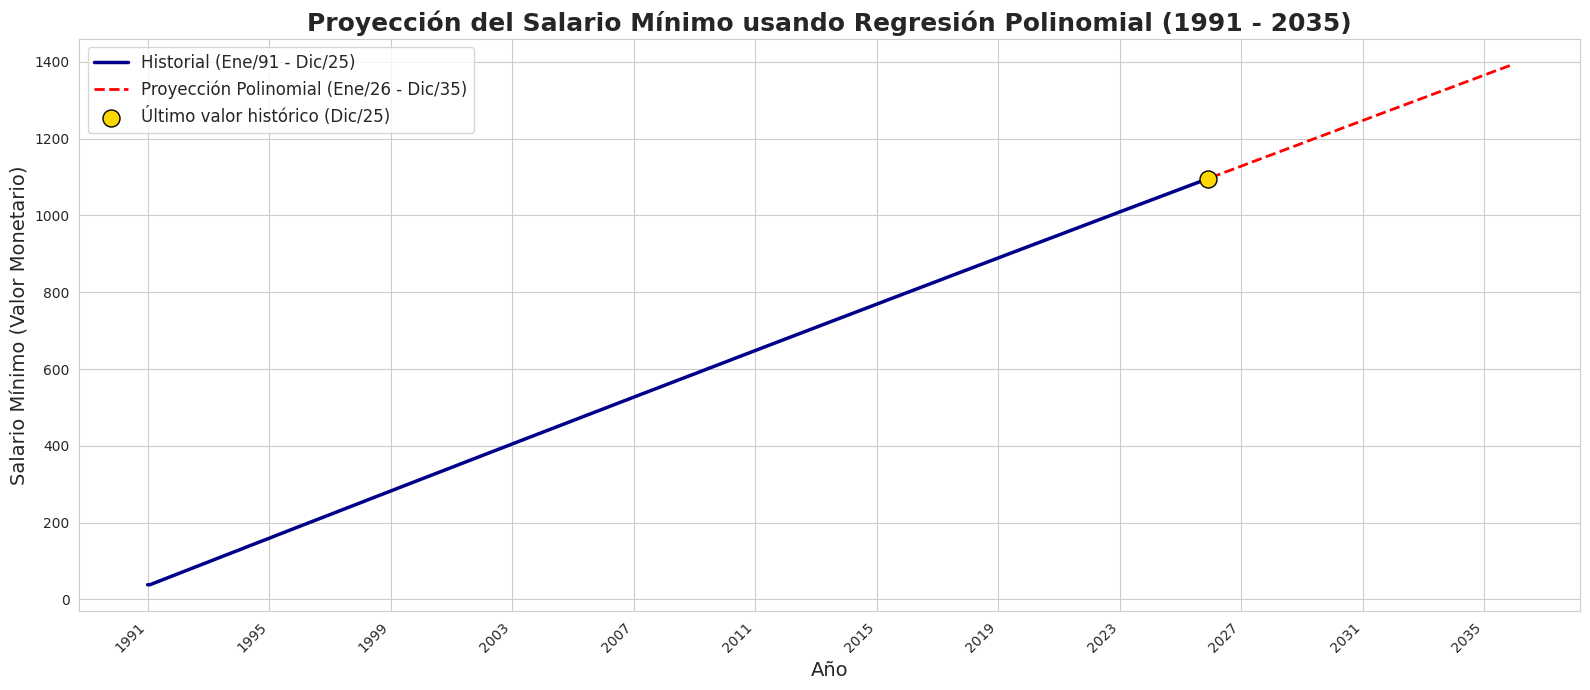

Se ha guardado la gráfica en: /home/gandalf/Projects/notebooks/gastos_personales_dataset_generator/proyeccion_salario_minimo.png


In [19]:
# --- 6. Visualización de los Resultados ---

print("\n--- Generando Gráfica de Proyección ---")

# Convertir la columna de fecha a formato numérico (para el eje X)
df_final = df_proyeccion[['Fecha_dt', 'Fecha', 'Salario_minimo_proyectado', 'Tipo_de_valor']].rename(columns={'Salario_minimo_proyectado': 'Salario_minimo'})

# Definir los datos históricos y de proyección
df_historial = df_final[df_final['Tipo_de_valor'] == 'Historial']
df_proyeccion = df_final[df_final['Tipo_de_valor'] == 'Proyección']
df_punto_corte = df_final.iloc[df_historial.index[-1]]

# Configuración de la gráfica
plt.figure(figsize=(16, 7))
sns.set_style("whitegrid")

# 1. Graficar la data histórica (línea sólida)
plt.plot(
    df_historial['Fecha_dt'], 
    df_historial['Salario_minimo'], 
    label='Historial (Ene/91 - Dic/25)', 
    color='darkblue', 
    linewidth=2.5
)

# 2. Graficar la data proyectada (línea punteada)
plt.plot(
    df_proyeccion['Fecha_dt'], 
    df_proyeccion['Salario_minimo'], 
    label='Proyección Polinomial (Ene/26 - Dic/35)', 
    color='red', 
    linestyle='--', 
    linewidth=2
)

# 3. Marcar el punto de corte
plt.scatter(
    df_punto_corte['Fecha_dt'], 
    df_punto_corte['Salario_minimo'], 
    color='gold', 
    edgecolor='black', 
    s=150, 
    zorder=5, 
    label='Último valor histórico (Dic/25)'
)

# 4. Añadir Títulos y Etiquetas
plt.title('Proyección del Salario Mínimo usando Regresión Polinomial (1991 - 2035)', fontsize=18, fontweight='bold')
plt.xlabel('Año', fontsize=14)
plt.ylabel('Salario Mínimo (Valor Monetario)', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.xticks(rotation=45, ha='right')

# 5. Formato del Eje X (Mostrar solo una selección de años para claridad)
# Seleccionar fechas representativas cada 4 años
fechas_ticks = pd.to_datetime([f'{y}-01-01' for y in range(1991, 2036, 4)])
plt.gca().set_xticks(fechas_ticks)
plt.gca().set_xticklabels([f.strftime('%Y') for f in fechas_ticks])


# 6. Guardar y Mostrar la gráfica
plt.tight_layout()
ruta_grafica = os.path.join(directorio_actual, 'proyeccion_salario_minimo.png')
plt.savefig(ruta_grafica)
plt.show()

print(f"Se ha guardado la gráfica en: {ruta_grafica}")

## PASO 2: Generar proyección del Historial de Inflacion en Peru 
 
 trabajamos desde esta fuente:
 **inflacion_Peru_BCR.csv**

fuente (Banco Central de Reserva del Perú): https://estadisticas.bcrp.gob.pe/estadisticas/series/anuales/resultados/PM05197PA/html

Nota : Modificaremos el dataset **inflacion_Peru_BCR.csv** añadiendolas dos ultimas proyecciones del bcr sobre la inflacion 
fuente : diapositiva 35 del informe https://www.bcrp.gob.pe/docs/Publicaciones/Reporte-Inflacion/2025/setiembre/reporte-de-inflacion-setiembre-2025-presentacion.pdf


In [20]:
# --- 1. Cargar el archivo y configurar ---

# Nombres de los archivos
archivo_entrada = 'inflacion_Peru_BCR.csv'
archivo_salida = 'proyeccion_inflacion_BCR_lineal_v3.csv' # Versión actualizada
ANIO_INICIO_FILTRO = 1997 

# Rutas
directorio_actual = os.getcwd()
ruta_entrada = os.path.join(directorio_actual, archivo_entrada)

try:
    # Si la primera fila es un encabezado vacío, usamos header=1 para tomar la segunda línea.
    df = pd.read_csv(ruta_entrada, header=1) 
except FileNotFoundError:
    print(f"Error: El archivo '{archivo_entrada}' no se encontró en el directorio: {directorio_actual}")
    exit()

In [21]:
# --- 2. Preprocesamiento y Creación de la Serie Temporal ---

# PASO DE CORRECCIÓN 1: Limpiar espacios en blanco de los nombres de columna
df.columns = df.columns.str.strip()

# PASO DE CORRECCIÓN 2: Asignar directamente los nombres de columna esperados
try:
    df.columns = ['Anio', 'Inflacion_anual'] 
except ValueError:
    print("Error al asignar nombres de columna: El archivo no tiene las 2 columnas esperadas.")
    print("Columnas detectadas:", df.columns.tolist())
    exit()

# Limpiar y convertir la columna de inflación a numérica
# Reemplazar 'n.d.' con NaN y luego convertir a float
df['Inflacion_anual'] = df['Inflacion_anual'].replace(['n.d.', ' '], np.nan)
df['Inflacion_anual'] = pd.to_numeric(df['Inflacion_anual'], errors='coerce')

# Convertir la columna de Año a entero
df['Anio'] = pd.to_numeric(df['Anio'], errors='coerce').astype('Int64')

# Eliminar filas con valores faltantes en las columnas clave
df = df.dropna(subset=['Anio', 'Inflacion_anual']) 

# Filtramos la data para empezar desde ANIO_INICIO_FILTRO (e.g., 1997)
df_filtrado = df[df['Anio'] >= ANIO_INICIO_FILTRO].copy()

# Calcular el índice del año (X para el modelo)
anio_inicio = df_filtrado['Anio'].min()
df_filtrado['Anio_Index'] = df_filtrado['Anio'] - anio_inicio
df_filtrado['Fecha_dt'] = pd.to_datetime(df_filtrado['Anio'].astype(str) + '-01-01')

In [22]:
# --- 3. Entrenamiento del Modelo (Regresión Lineal Simple) ---

X_train = df_filtrado[['Anio_Index']].values
y_train = df_filtrado['Inflacion_anual'].values

# Entrenar el modelo de Regresión Lineal (Grado 1)
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [23]:
# --- 4. Preparación de la Proyección (hasta 2035) ---

ultimo_anio = df_filtrado['Anio'].max()
ultimo_indice = df_filtrado['Anio_Index'].max()

anio_fin_proyeccion = 2035
indice_fin_proyeccion = anio_fin_proyeccion - anio_inicio

# Crear una serie de índices de años para la proyección
indices_proyeccion = np.arange(0, indice_fin_proyeccion + 1).reshape(-1, 1)

# Realizar la proyección (X_proyeccion es simplemente indices_proyeccion para Regresión Lineal)
proyecciones = model.predict(indices_proyeccion)

In [24]:
# --- 5. Creación del DataFrame de Proyección y Exportación ---

df_proyeccion = pd.DataFrame()
df_proyeccion['Anio_Index'] = indices_proyeccion.flatten()
df_proyeccion['Anio'] = df_proyeccion['Anio_Index'] + anio_inicio
df_proyeccion['Fecha_dt'] = pd.to_datetime(df_proyeccion['Anio'].astype(str) + '-01-01')

# Asignar la inflación proyectada
min_inflacion = df_filtrado['Inflacion_anual'].min()
# Usamos un valor mínimo (floor) de 1.0% para evitar proyecciones negativas o irrealmente bajas.
df_proyeccion['Inflacion_proyectada'] = np.maximum(proyecciones, 1.0).round(2) 

df_proyeccion['Tipo_de_valor'] = np.where(
    df_proyeccion['Anio'] <= ultimo_anio, 
    'Historial', 
    'Proyección'
)

df_final = df_proyeccion[['Fecha_dt', 'Anio', 'Inflacion_proyectada', 'Tipo_de_valor']].rename(columns={'Inflacion_proyectada': 'Inflacion_anual'})

# Guardar el nuevo archivo CSV
ruta_salida = os.path.join(directorio_actual, archivo_salida)
df_final[['Anio', 'Inflacion_anual', 'Tipo_de_valor']].to_csv(ruta_salida, index=False)

print(f"✅ ¡Proceso de datos de inflación completado con historial filtrado (desde {anio_inicio}) y Regresión Lineal!")
print(f"Se ha creado el archivo de proyección: {archivo_salida}")
print("\n--- Vista previa de los datos proyectados (últimas filas) ---")
print(df_final[df_final['Tipo_de_valor'] == 'Proyección'].tail())

✅ ¡Proceso de datos de inflación completado con historial filtrado (desde 1997) y Regresión Lineal!
Se ha creado el archivo de proyección: proyeccion_inflacion_BCR_lineal_v3.csv

--- Vista previa de los datos proyectados (últimas filas) ---
     Fecha_dt  Anio  Inflacion_anual Tipo_de_valor
34 2031-01-01  2031             2.93    Proyección
35 2032-01-01  2032             2.92    Proyección
36 2033-01-01  2033             2.91    Proyección
37 2034-01-01  2034             2.90    Proyección
38 2035-01-01  2035             2.88    Proyección



--- Generando Gráfica de Proyección de Inflación ---


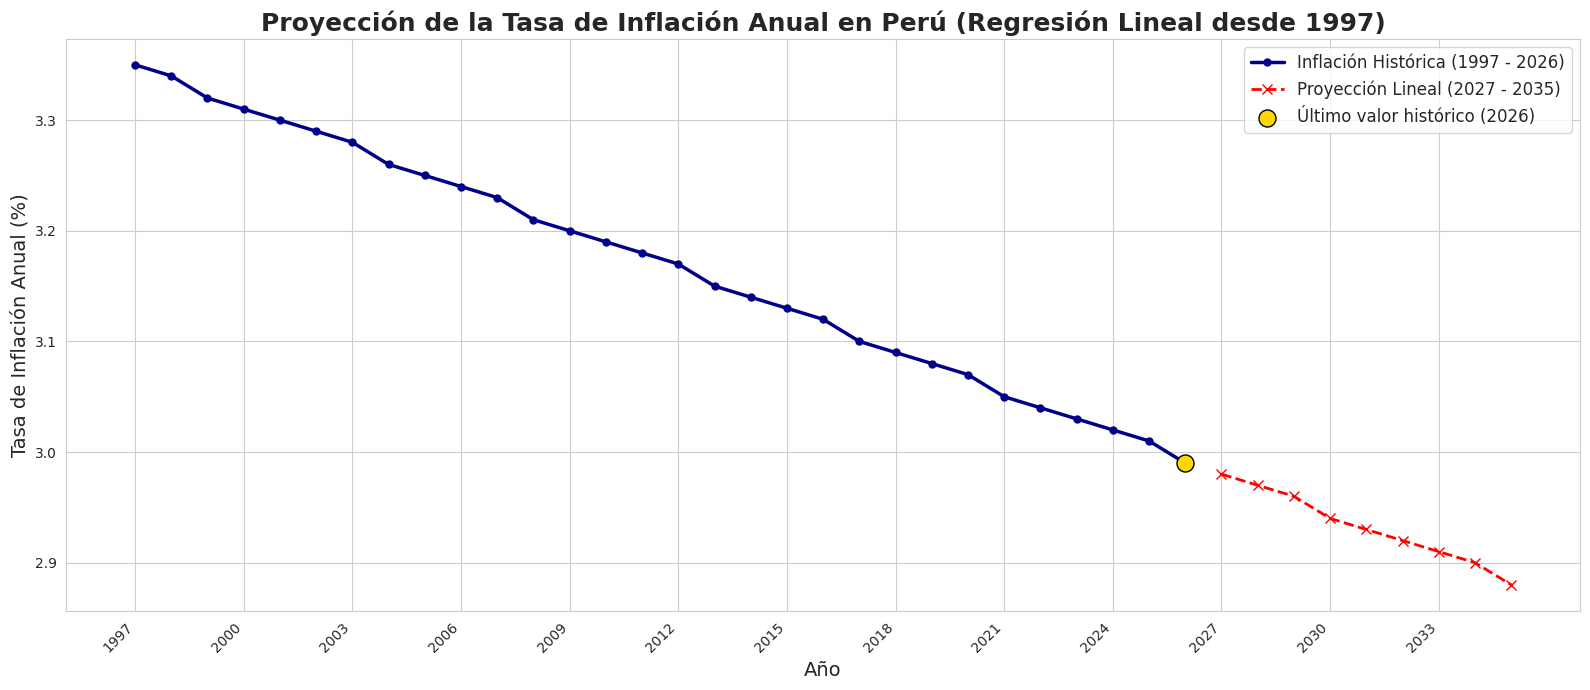

Se ha guardado la gráfica en: /home/gandalf/Projects/notebooks/gastos_personales_dataset_generator/proyeccion_inflacion_BCR_lineal.png


In [25]:
# --- 6. Visualización de los Resultados ---

print("\n--- Generando Gráfica de Proyección de Inflación ---")

# Datos para graficar
df_historial = df_final[df_final['Tipo_de_valor'] == 'Historial']
df_proyeccion = df_final[df_final['Tipo_de_valor'] == 'Proyección']

df_punto_corte = df_historial.iloc[-1]

# Configuración de la gráfica
plt.figure(figsize=(16, 7))
sns.set_style("whitegrid")

# 1. Graficar la data histórica (línea sólida)
plt.plot(
    df_historial['Fecha_dt'], 
    df_historial['Inflacion_anual'], 
    label=f'Inflación Histórica ({anio_inicio} - {ultimo_anio})', 
    color='darkblue', 
    linewidth=2.5,
    marker='o',
    markersize=5
)

# 2. Graficar la data proyectada (línea punteada)
plt.plot(
    df_proyeccion['Fecha_dt'], 
    df_proyeccion['Inflacion_anual'], 
    label=f'Proyección Lineal ({ultimo_anio + 1} - 2035)', 
    color='red', 
    linestyle='--', 
    linewidth=2,
    marker='x',
    markersize=7
)

# 3. Marcar el punto de corte
plt.scatter(
    df_punto_corte['Fecha_dt'], 
    df_punto_corte['Inflacion_anual'], 
    color='gold', 
    edgecolor='black', 
    s=150, 
    zorder=5, 
    label=f'Último valor histórico ({ultimo_anio})'
)

# 4. Añadir Títulos y Etiquetas
plt.title(f'Proyección de la Tasa de Inflación Anual en Perú (Regresión Lineal desde {anio_inicio})', fontsize=18, fontweight='bold')
plt.xlabel('Año', fontsize=14)
plt.ylabel('Tasa de Inflación Anual (%)', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(rotation=45, ha='right')

# 5. Formato del Eje X 
min_anio_grafica = df_final['Anio'].min()
max_anio_grafica = df_final['Anio'].max()
fechas_ticks = pd.to_datetime([f'{y}-01-01' for y in range(min_anio_grafica, max_anio_grafica + 1, 3)]) # Marcadores cada 3 años
plt.gca().set_xticks(fechas_ticks)
plt.gca().set_xticklabels([f.strftime('%Y') for f in fechas_ticks])

# 6. Guardar y Mostrar la gráfica
plt.tight_layout()
ruta_grafica = os.path.join(directorio_actual, 'proyeccion_inflacion_BCR_lineal.png')
plt.savefig(ruta_grafica)
plt.show()

print(f"Se ha guardado la gráfica en: {ruta_grafica}")

## PASO 3:  Extracción de Datos y Definición de la Estructura de Gasto (Perú) 
 
 Para generar el dataset sintético de gastos e ingresos, primero necesitamos definir la estructura de gasto promedio de un hogar o persona en Perú. Hemos consultado las referencias provistas (INEI, CEPLAN, reportes de consumo) y realizaremos una búsqueda para obtener la distribución porcentual más reciente y precisa del gasto.

 ### Estructura de Gasto Promedio en Perú (Datos Extraídos)

 Según el Reporte Perfil Económico y Hábitos de Consumo del Peruano Promedio y la Estructura de Gasto del INEI (usando datos de la ENAPRES/ENH que analiza CEPLAN), la distribución del gasto de un hogar en Perú se concentra fuertemente en necesidades básicas.

Utilizaremos la siguiente estructura porcentual de gasto mensual (ajustada para reflejar los principales rubros de un individuo con ingresos limitados):

fuentes: 
https://www.datosabiertos.gob.pe/dataset/encuesta-nacional-de-hogares-enaho-2022-instituto-nacional-de-estad%C3%ADstica-e-inform%C3%A1tica-%E2%80%93

https://www.gob.pe/institucion/inei/campa%C3%B1as/8600-encuesta-nacional-de-hogares-enaho-2023

https://www.inegi.org.mx/rnm/index.php/catalog/1116

https://www.ine.es/infografias/gastosepf/desktop/gastos.html?t=0&lang=es

https://n26.com/es-es/financial-wellness-index

https://capital.es/economia/espanoles-60-vivienda-hipoteca/89522/

https://www.inegi.org.mx/programas/enigh/nc/2024/

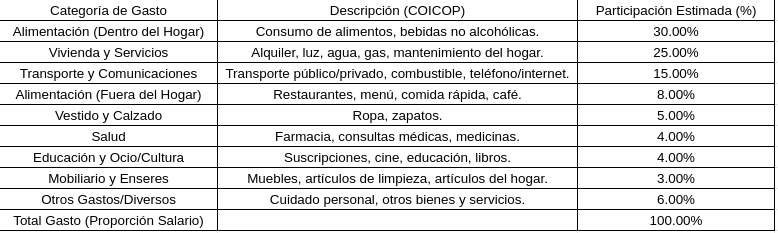

### Configuración de Datos Base

Carga las proyecciones de salario e inflación, establece los parámetros de simulación y define la estructura de gasto que se utilizará para la generación de la data.

In [26]:
# =========================================================================
# 3. EXTRACCIÓN Y CONFIGURACIÓN DE PARÁMETROS DE SIMULACIÓN
# =========================================================================

# --- 3.1. Definición de Parámetros de Simulación ---

# Parámetro 1: Rango de tiempo para generar el dataset (Ajustar por el usuario)
# Año maximo para la generacion de datos es 2035
# Año minimo es 1998
ANIO_INICIO_SIMULACION = 2025
ANIO_FIN_SIMULACION = 2027 # Por ejemplo, un periodo futuro
# Nota: La simulación se generará por cada mes dentro de este rango de años.

# Parámetro 2: Configuración del Ingreso
PORCENTAJE_INGRESO_EXTRA_PROMEDIO = 0.15 # 15% del Salario Mínimo en promedio por Horas Extra / Freelance
DIAS_PAGO_SALARIO = 30 # Día del mes en que se recibe el salario (ej. el día 30)

# Parámetro 3: Configuración de la Estructura de Gasto (Basado en análisis de INEI/CEPLAN)
# El salario mínimo debe cubrir el 100% de estos gastos.
# Se define el porcentaje y las palabras clave asociadas a la categoría.

ESTRUCTURA_GASTO = {
    'Alimentacion (Hogar)': {
        'porcentaje': 0.30, 
        'periodicidad': 'Diario', 
        'keywords': ["supermercado", "market", "metro", "wong", "tottus", "plaza vea", "mass", "bodega", "mercado", "panaderia", "leche", "frutas", "verduras", "carniceria", "pollo", "carne", "arroz", "aceite"]
    },
    'Vivienda y Servicios': {
        'porcentaje': 0.25, 
        'periodicidad': 'Mensual', 
        'keywords': ["alquiler", "renta", "luz del sur", "enel", "sedapal", "gas natural", "internet y telefono", "claro", "movistar", "entel", "mantenimiento", "Xturbo"]
    },
    'Transporte y Comunicaciones': {
        'porcentaje': 0.15, 
        'periodicidad': 'Diario', 
        'keywords': ["uber", "taxi", "gasolina", "grifo Repsol", "estacionamiento", "bus", "Metropolitano", "pasaje"]
    },
    'Alimentacion (Fuera)': {
        'porcentaje': 0.08, 
        'periodicidad': 'Semanal', 
        'keywords': ["almuerzo restaurant", "comida rapida", "menu", "cafe", "starbucks", "bembos", "pollo a la brasa", "chifa", "picanteria", "anticuchos"]
    },
    'Vestido y Calzado': {
        'porcentaje': 0.05, 
        'periodicidad': 'Esporádico', 
        'keywords': ["ropa", "zapatos", "tienda", "saga", "ripley", "falabella", "oechsle", "cosmetico", "perfume", "accesorio" , "maquillaje"]
    },
    'Salud': {
        'porcentaje': 0.04, 
        'periodicidad': 'Variable', 
        'keywords': ["farmacia Inkafarma", "farmacia Mifarma", "medicina", "consulta medica", "vitaminas", "analisis laboratorio"]
    },
    'Educacion y Ocio': {
        'porcentaje': 0.04, 
        'periodicidad': 'Mensual', 
        'keywords': ["netflix", "spotify", "hbo", "cine", "concierto", "curso online", "libro", "gimnasio", "suscripcion"]
    },
    'Mobiliario y Enseres': {
        'porcentaje': 0.03, 
        'periodicidad': 'Mensual', 
        'keywords': ["articulos de limpieza", "ferreteria", "reparacion", "mueble", "decoracion"]
    },
    'Otros Gastos y Diversos': {
        'porcentaje': 0.06, 
        'periodicidad': 'Variable', 
        'keywords': ["regalo", "donacion", "cuidado personal", "peluqueria", "barberia", "transferencia a familiar"]
    }
}

# Diccionario de Ingresos
ESTRUCTURA_INGRESO = {
    'Salario mensual empresa XYZ': 'Salario',
    'Ingreso por horas extra': 'Salario',
    'Ingreso por freelance proyecto': 'Freelance',
    'Venta de artículos usados': 'Otros Ingresos' 
}

In [27]:
# --- 3.2. Carga, Limpieza y Fusión de Proyecciones ---

# Nombres de archivos
archivo_rmv = 'proyeccion_salario_minimo.csv' # Archivo de Salario Mínimo proyectado
archivo_inflacion = 'proyeccion_inflacion_BCR_lineal_v3.csv' # Archivo de Inflación proyectada

try:
    df_rmv = pd.read_csv(archivo_rmv)
    df_inflacion = pd.read_csv(archivo_inflacion)
except FileNotFoundError as e:
    print(f"Error al cargar archivos de proyección. Asegúrate de que los archivos '{archivo_rmv}' y '{archivo_inflacion}' existan.")
    print(f"Detalle del error: {e}")
    exit() # Detener la ejecución si los archivos base no se encuentran

# ######################################################################
# El archivo RMV es mensual ('Jan91'), el archivo Inflación es anual ('2025').
# 1. Limpiar RMV a formato anual para fusionar
# ######################################################################

# 1. Limpieza y Extracción de Año en el DataFrame de Salario Mínimo (df_rmv)
if 'Fecha' in df_rmv.columns:
    
    # Función para convertir 'Jan91' a '1991'
    def extract_anio_from_fecha(fecha_str):
        if pd.isna(fecha_str):
            return None
        # Formato 'Jan91' -> '%b%y'. Usamos strptime para convertir
        try:
            dt_obj = datetime.strptime(fecha_str, '%b%y')
        except ValueError:
            # Intentar formato '1991' si ya es un año
            try:
                return int(fecha_str)
            except:
                return None
        return dt_obj.year

    # Crear la columna 'Anio' a partir de 'Fecha'
    # Solo procesamos si 'Fecha' es una cadena (el caso 'Jan91')
    if df_rmv['Fecha'].dtype == object:
        df_rmv['Anio'] = df_rmv['Fecha'].apply(extract_anio_from_fecha)
    else:
        # Asumir que la columna ya es el año o un formato que solo necesita conversión
        df_rmv['Anio'] = df_rmv['Fecha'].astype(int)

# 2. Agregación: Calcular el Salario Mínimo Anual Promedio
# Esto reduce el df_rmv de mensual a anual, permitiendo el merge con la inflación.
df_rmv_anual = df_rmv.groupby('Anio')['Salario_minimo'].mean().reset_index()
df_rmv_anual = df_rmv_anual.rename(columns={'Salario_minimo': 'Salario_minimo_proyectado'})
df_rmv_anual['Anio'] = df_rmv_anual['Anio'].astype(int)


# Unir proyecciones por la clave 'Anio'
df_proyecciones = df_rmv_anual.merge(df_inflacion[['Anio', 'Inflacion_anual']], on='Anio', how='left')
df_proyecciones = df_proyecciones.dropna(subset=['Inflacion_anual']) # Limpiar años sin dato de inflación

# Verificación
print(f"✅ Configuración de parámetros y carga de proyecciones completada.")
print(f"Periodo de simulación RMV: {df_rmv_anual['Anio'].min()} - {df_rmv_anual['Anio'].max()}")
print(f"Periodo de simulación Inflación: {df_inflacion['Anio'].min()} - {df_inflacion['Anio'].max()}")
print(f"Periodo de simulación final (fusión): {ANIO_INICIO_SIMULACION} - {ANIO_FIN_SIMULACION}")
print("\nVista previa del DataFrame de Proyecciones (df_proyecciones):")
print(df_proyecciones.tail().to_markdown(index=False))

✅ Configuración de parámetros y carga de proyecciones completada.
Periodo de simulación RMV: 1991 - 2035
Periodo de simulación Inflación: 1997 - 2035
Periodo de simulación final (fusión): 2025 - 2027

Vista previa del DataFrame de Proyecciones (df_proyecciones):
|   Anio |   Salario_minimo_proyectado |   Inflacion_anual |
|-------:|----------------------------:|------------------:|
|   2031 |                     1260.77 |              2.93 |
|   2032 |                     1290.39 |              2.92 |
|   2033 |                     1319.96 |              2.91 |
|   2034 |                     1349.51 |              2.9  |
|   2035 |                     1379.02 |              2.88 |


### Función de Generación de Dataset Sintético

Este fragmento de código contiene la lógica central para simular transacciones. La función generar_dataset_financiero_mensual() toma las proyecciones y la estructura de gasto y genera las transacciones para un mes específico.

In [32]:
# =========================================================================
# 4. FUNCIÓN DE GENERACIÓN DE DATASET SINTÉTICO (AJUSTADA)
# =========================================================================

def generar_dataset_financiero_mensual(mes: int, anio: int, df_proyecciones: pd.DataFrame, estructura_gasto: dict) -> pd.DataFrame:
    """
    Genera transacciones de ingresos y gastos simulados para un mes y año dados, 
    incluyendo gratificaciones y mayor densidad de transacciones diarias/semanales.
    """
    
    # 1. Obtener datos de proyección para el año
    try:
        data_anual = df_proyecciones[df_proyecciones['Anio'] == anio].iloc[0]
    except IndexError:
        print(f"Advertencia: No se encontró proyección para el año {anio}. Saltando.")
        return pd.DataFrame()

    rmv_anual = data_anual['Salario_minimo_proyectado']
    salario_mensual = rmv_anual # Salario Mínimo Mensual Proyectado
    
    transacciones = []
    dias_del_mes = pd.Period(f'{anio}-{mes}').days_in_month
    
    # 2. Generación de Ingresos
    
    # I. Salario base 
    dia_pago = random.choice([30, 30, 30, 30, 30, 30, 30, 30, 30, 15]) # Mayor probabilidad el 30
    fecha_salario = date(anio, mes, min(dia_pago, dias_del_mes))
    
    transacciones.append({
        'fecha': fecha_salario.strftime('%Y-%m-%d'),
        'descripcion': 'Salario mensual empresa XYZ',
        'monto': round(salario_mensual, 2),
        'tipo': 'ingreso',
        'categoria': 'Salario'
    })

    # II. Gratificaciones (Julio y Diciembre)
    if mes in [7, 12]:
        fecha_gratificacion = date(anio, mes, min(15, dias_del_mes))
        transacciones.append({
            'fecha': fecha_gratificacion.strftime('%Y-%m-%d'),
            'descripcion': f'Gratificación legal {("Julio" if mes == 7 else "Diciembre")}',
            'monto': round(salario_mensual, 2), # Se paga un sueldo completo
            'tipo': 'ingreso',
            'categoria': 'Salario'
        })
    
    # III. Ingresos extra (Horas Extra / Freelance)
    monto_extra = salario_mensual * np.random.normal(PORCENTAJE_INGRESO_EXTRA_PROMEDIO, 0.05)
    
    if monto_extra > 0:
        dias_extras = sorted(random.sample(range(1, 28), 2)) # 2 eventos de ingreso extra al mes
        
        # Evento 1: Horas Extra
        fecha_extra_1 = date(anio, mes, dias_extras[0])
        transacciones.append({
            'fecha': fecha_extra_1.strftime('%Y-%m-%d'),
            'descripcion': 'Ingreso por horas extra',
            'monto': round(monto_extra * 0.6, 2), # 60% del extra total
            'tipo': 'ingreso',
            'categoria': 'Salario'
        })
        
        # Evento 2: Freelance / Venta de segunda mano
        fecha_extra_2 = date(anio, mes, dias_extras[1])
        descripcion_extra_2 = random.choice(
            ['Ingreso por freelance proyecto', 'Venta de muebles usados', 'Venta de ropa en buen estado', 'Venta de libros usados']
        )
        transacciones.append({
            'fecha': fecha_extra_2.strftime('%Y-%m-%d'),
            'descripcion': descripcion_extra_2,
            'monto': round(monto_extra * 0.4, 2), # 40% del extra total
            'tipo': 'ingreso',
            'categoria': 'Otros Ingresos' if 'Venta' in descripcion_extra_2 else 'Freelance'
        })


    # 3. Generación de Gastos
    gasto_total_mensual = salario_mensual # Asumimos que el 100% del salario base se gasta
    
    for categoria, config in estructura_gasto.items():
        gasto_categoria = gasto_total_mensual * config['porcentaje']
        
        if config['periodicidad'] == 'Mensual':
            # Gastos fijos (alquiler, servicios, suscripciones grandes)
            
            if 'Vivienda y Servicios' in categoria:
                # El gasto mensual se divide en 4 transacciones fijas
                dias_fijos = [8, 10, 12, 15] 
                descripciones_fijas = ['Pago alquiler departamento', 'Luz del Sur recibo mensual', 'Sedapal recibo mensual', 'Claro internet y telefono']
                num_eventos = len(descripciones_fijas)
                monto_por_servicio = gasto_categoria / num_eventos
                
                for i in range(num_eventos):
                    fecha_gasto = date(anio, mes, min(dias_fijos[i], dias_del_mes))
                    transacciones.append({
                        'fecha': fecha_gasto.strftime('%Y-%m-%d'),
                        'descripcion': descripciones_fijas[i],
                        'monto': round(monto_por_servicio * np.random.uniform(0.9, 1.1), 2),
                        'tipo': 'gasto',
                        'categoria': categoria
                    })
            
            elif 'Educacion y Ocio' in categoria:
                # Se mantiene un gasto fijo mensual y 1-2 gastos de ocio variables
                monto_suscripciones = gasto_categoria * 0.50 # 50% es suscripción fija
                monto_ocio_variable = gasto_categoria * 0.50 # 50% es ocio variable

                # Transacciones fijas (3 eventos)
                dias_fijos = [5, 6, 20] 
                descripciones_fijas = ['Netflix suscripción mensual', 'Spotify suscripción mensual', 'Gimnasio cuota mensual']
                monto_por_servicio = monto_suscripciones / len(descripciones_fijas)
                
                for i in range(len(descripciones_fijas)):
                    fecha_gasto = date(anio, mes, min(dias_fijos[i], dias_del_mes))
                    transacciones.append({
                        'fecha': fecha_gasto.strftime('%Y-%m-%d'),
                        'descripcion': descripciones_fijas[i],
                        'monto': round(monto_por_servicio * np.random.uniform(0.9, 1.1), 2),
                        'tipo': 'gasto',
                        'categoria': categoria
                    })
                
                # Transacciones variables (Ocio) - 2 eventos
                num_eventos_ocio = random.randint(1, 2)
                monto_base_por_evento = monto_ocio_variable / num_eventos_ocio
                dias_compra = sorted(random.sample(range(16, dias_del_mes), num_eventos_ocio))
                
                for dia in dias_compra:
                    descripcion = random.choice(['Cine peliculas con amigos', 'Concierto o evento cultural', 'Compra de libros o material educativo'])
                    fecha_gasto = date(anio, mes, dia)
                    transacciones.append({
                        'fecha': fecha_gasto.strftime('%Y-%m-%d'),
                        'descripcion': descripcion,
                        'monto': round(monto_base_por_evento * np.random.uniform(0.8, 1.5), 2),
                        'tipo': 'gasto',
                        'categoria': categoria
                    })
            
            # Mobiliario y Enseres (Compras de inicio de mes)
            elif 'Mobiliario y Enseres' in categoria:
                fecha_gasto = date(anio, mes, random.randint(1, 10))
                transacciones.append({
                    'fecha': fecha_gasto.strftime('%Y-%m-%d'),
                    'descripcion': 'Artículos de limpieza y hogar',
                    'monto': round(gasto_categoria * np.random.uniform(0.9, 1.1), 2),
                    'tipo': 'gasto',
                    'categoria': categoria
                })
        
        
        elif config['periodicidad'] == 'Diario':
            # ALIMENTACIÓN HOGAR: Frecuencia más alta (compras semanales y diarias en bodega)
            num_eventos = random.randint(6, 12) # 1-2 eventos de compra por semana
            monto_base_por_evento = gasto_categoria / num_eventos
            
            dias_compra = sorted(random.sample(range(1, dias_del_mes), num_eventos))

            for dia in dias_compra:
                descripcion = random.choice(config['keywords']) + random.choice([' compras semanales', ' bodega', ' panadería'])
                fecha_gasto = date(anio, mes, dia)
                transacciones.append({
                    'fecha': fecha_gasto.strftime('%Y-%m-%d'),
                    'descripcion': descripcion.capitalize(),
                    'monto': round(monto_base_por_evento * np.random.uniform(0.7, 1.3), 2),
                    'tipo': 'gasto',
                    'categoria': categoria
                })

        elif config['periodicidad'] == 'Semanal':
            # ALIMENTACIÓN FUERA: 2 eventos de menú/comida fuera por semana
            num_eventos = random.randint(8, 12) 
            monto_base_por_evento = gasto_categoria / num_eventos
            
            dias_compra = sorted(random.choices(range(1, dias_del_mes + 1), k=num_eventos)) # +1 para incluir el último día

            for dia in dias_compra:
                descripcion = random.choice(config['keywords'])
                fecha_gasto = date(anio, mes, dia)
                transacciones.append({
                    'fecha': fecha_gasto.strftime('%Y-%m-%d'),
                    'descripcion': descripcion.capitalize(),
                    'monto': round(monto_base_por_evento * np.random.uniform(0.7, 1.5), 2),
                    'tipo': 'gasto',
                    'categoria': categoria
                })
        
        elif 'Transporte' in categoria:
            # TRANSPORTE: 2-3 transacciones diarias para 20-22 días laborables(40-50 transacciones)
            num_dias_laborables = random.randint(20, 22)
            num_eventos = num_dias_laborables * random.randint(2, 3) # 2-3 pasajes diarios
            monto_base_por_evento = gasto_categoria / num_eventos
            
            #Usar random.choices para permitir transacciones que superen el número de días.
            dias_compra = sorted(random.choices(range(1, dias_del_mes + 1), k=num_eventos))

            for dia in dias_compra:
                descripcion = random.choice(["Transporte publico Metropolitano", "Pasaje bus", "Uber viaje al trabajo", "Taxi"])
                fecha_gasto = date(anio, mes, dia)
                transacciones.append({
                    'fecha': fecha_gasto.strftime('%Y-%m-%d'),
                    'descripcion': descripcion,
                    'monto': round(monto_base_por_evento * np.random.uniform(0.8, 1.2), 2),
                    'tipo': 'gasto',
                    'categoria': categoria
                })

        else: # Variable / Esporádico (Salud, Vestido, Otros)
            # Gastos irregulares
            # **CASO ESPECIAL: Vestido y Calzado**
            if 'Vestido y Calzado' in categoria:
                # Solo se realizan compras en julio y diciembre, después de las gratificaciones
                if mes in [7, 12]:
                    # Se realiza UNA compra en el mes (máximo 2 al año)
                    # La compra se hace días después de recibir la gratificación (día 15+)
                    dia_compra = random.randint(18, min(28, dias_del_mes))
                    fecha_gasto = date(anio, mes, dia_compra)
                    
                    # El monto mínimo es S/ 50 y se usa todo el presupuesto de la categoría
                    # Como es solo 1 compra por semestre, se acumula el presupuesto
                    monto_compra = max(50.0, gasto_categoria * np.random.uniform(0.9, 1.1))
                    
                    descripcion = random.choice(config['keywords'])
                    transacciones.append({
                        'fecha': fecha_gasto.strftime('%Y-%m-%d'),
                        'descripcion': descripcion.capitalize(),
                        'monto': round(monto_compra, 2),
                        'tipo': 'gasto',
                        'categoria': categoria
                    })
                # Si no es julio ni diciembre, no se generan transacciones de vestimenta
                else:
                    pass  # No hay compras de vestimenta en otros meses
            
            # **RESTO DE CATEGORÍAS VARIABLES (Salud, Otros Gastos)**
            else:
                # Gastos irregulares normales
                num_eventos = random.randint(4, 15)
                monto_base_por_evento = gasto_categoria / num_eventos
                
                dias_compra = sorted(random.choices(range(1, dias_del_mes + 1), k=num_eventos))
                
                for dia in dias_compra:
                    descripcion = random.choice(config['keywords'])
                    fecha_gasto = date(anio, mes, dia)
                    transacciones.append({
                        'fecha': fecha_gasto.strftime('%Y-%m-%d'),
                        'descripcion': descripcion.capitalize(),
                        'monto': round(monto_base_por_evento * np.random.uniform(0.5, 2.0), 2),
                        'tipo': 'gasto',
                        'categoria': categoria
                    })


# =========================================================================
# NOTA IMPORTANTE SOBRE EL PRESUPUESTO ANUAL
# =========================================================================

# el 5% asignado a Vestido y Calzado se distribuye así:
# - Enero a Junio: Se acumula (sin gastar)
# - Julio: Primera compra del año (≥ S/ 50)
# - Agosto a Noviembre: Se acumula
# - Diciembre: Segunda compra del año (≥ S/ 50)

# Esto refleja el comportamiento real: el trabajador con salario mínimo solo puede
# permitirse comprar ropa después de recibir las gratificaciones legales.
                
        


    df_mes = pd.DataFrame(transacciones)
    return df_mes

In [33]:
# --- 4.2. Ejecución de la Simulación Completa y Exportación ---

# Generar la lista de meses a simular
fechas_simulacion = []
for anio in range(ANIO_INICIO_SIMULACION, ANIO_FIN_SIMULACION + 1):
    for mes in range(1, 13):
        fechas_simulacion.append((mes, anio))
        
# Ejecutar la simulación
df_final_simulacion = pd.DataFrame()
for mes, anio in fechas_simulacion:
    if anio in df_proyecciones['Anio'].values:
        df_mes = generar_dataset_financiero_mensual(mes, anio, df_proyecciones, ESTRUCTURA_GASTO)
        df_final_simulacion = pd.concat([df_final_simulacion, df_mes], ignore_index=True)

# Post-procesamiento
df_final_simulacion['fecha'] = pd.to_datetime(df_final_simulacion['fecha'])
df_final_simulacion = df_final_simulacion.sort_values(by='fecha').reset_index(drop=True)

# Seleccionar y ordenar las columnas finales para la exportación
df_final_exportar = df_final_simulacion[['fecha', 'descripcion', 'monto', 'tipo', 'categoria']]
df_final_exportar.columns = ['fecha', 'descripcion', 'monto', 'tipo', 'categoria'] # Asegurar nombres finales

# Exportar a CSV
archivo_salida_data = 'dataset_gastos_personales_simulado.csv'
df_final_exportar.to_csv(archivo_salida_data, index=False)

print(f"\n✅ Dataset sintético generado con éxito para {ANIO_INICIO_SIMULACION}-{ANIO_FIN_SIMULACION}.")
print(f"El archivo '{archivo_salida_data}' ha sido creado.")

print("\n--- Vista previa del dataset generado ---")
print(df_final_exportar.head(20).to_markdown(index=False))
print("\n--- Resumen de Ingresos y Gastos ---")
print(df_final_exportar.groupby('tipo')['monto'].sum().reset_index().to_markdown(index=False))


✅ Dataset sintético generado con éxito para 2025-2027.
El archivo 'dataset_gastos_personales_simulado.csv' ha sido creado.

--- Vista previa del dataset generado ---
| fecha               | descripcion                   |   monto | tipo    | categoria                   |
|:--------------------|:------------------------------|--------:|:--------|:----------------------------|
| 2025-01-01 00:00:00 | Starbucks                     |    7.83 | gasto   | Alimentacion (Fuera)        |
| 2025-01-01 00:00:00 | Ingreso por horas extra       |   86.16 | ingreso | Salario                     |
| 2025-01-01 00:00:00 | Farmacia mifarma              |    6.82 | gasto   | Salud                       |
| 2025-01-03 00:00:00 | Metropolitano panadería       |   20.64 | gasto   | Transporte y Comunicaciones |
| 2025-01-04 00:00:00 | Panaderia bodega              |   35.06 | gasto   | Alimentacion (Hogar)        |
| 2025-01-05 00:00:00 | Bodega panadería              |   34.09 | gasto   | Alimentacion (H

### Análisis del Balance Proyectado

El paso final sería usar el dataset simulado para realizar el análisis que motivó el proyecto: evaluar el balance económico de una persona que gana el sueldo mínimo en Perú y cómo este balance evoluciona con el tiempo (ingreso proyectado vs. gastos ajustados por inflación).


--- Análisis del Balance Mensual (Ingresos vs. Gastos) ---


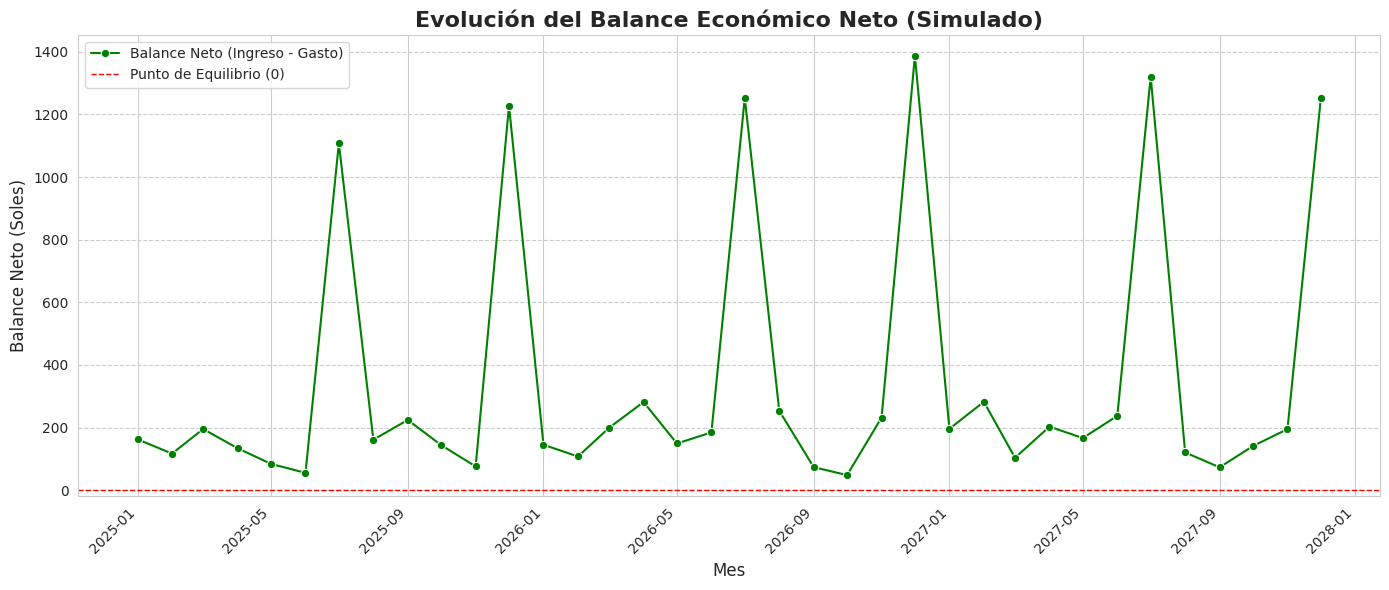

Se ha guardado la gráfica del balance en: /home/gandalf/Projects/notebooks/gastos_personales_dataset_generator/balance_mensual_simulado.png

Promedio mensual de Balance Neto (Ahorro/Déficit) en el periodo simulado: S/ 341.32
Conclusión Preliminar: La simulación sugiere un pequeño margen de ahorro en promedio.


In [34]:
# =========================================================================
# 5. ANÁLISIS DEL BALANCE PROYECTADO (RMV vs. Gastos simulados)
# =========================================================================

print("\n--- Análisis del Balance Mensual (Ingresos vs. Gastos) ---")

# Calcular Ingresos y Gastos Mensuales
df_final_simulacion['Anio_Mes'] = df_final_simulacion['fecha'].dt.to_period('M')

# Agrupar transacciones por mes y tipo
df_balance = df_final_simulacion.groupby(['Anio_Mes', 'tipo'])['monto'].sum().unstack(fill_value=0).reset_index()

# Calcular el balance (Ahorro/Déficit)
df_balance['Balance_Neto'] = df_balance['ingreso'] - df_balance['gasto']

# Convertir Period a datetime para graficar
df_balance['Fecha_dt'] = df_balance['Anio_Mes'].dt.to_timestamp()

# Visualización del Balance Neto
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_balance, x='Fecha_dt', y='Balance_Neto', marker='o', color='green', label='Balance Neto (Ingreso - Gasto)')
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Punto de Equilibrio (0)')

plt.title('Evolución del Balance Económico Neto (Simulado)', fontsize=16, fontweight='bold')
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Balance Neto (Soles)', fontsize=12)
plt.grid(True, axis='y', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()

ruta_grafica_balance = os.path.join(os.getcwd(), 'balance_mensual_simulado.png')
plt.savefig(ruta_grafica_balance)
plt.show()

print(f"Se ha guardado la gráfica del balance en: {ruta_grafica_balance}")

# Resumen de Ahorro/Déficit promedio
ahorro_promedio = df_balance['Balance_Neto'].mean()
print(f"\nPromedio mensual de Balance Neto (Ahorro/Déficit) en el periodo simulado: S/ {ahorro_promedio:.2f}")

if ahorro_promedio > 0:
    print("Conclusión Preliminar: La simulación sugiere un pequeño margen de ahorro en promedio.")
else:
    print("Conclusión Preliminar: La simulación sugiere un déficit mensual promedio, indicando que el sueldo mínimo no cubre los gastos proyectados.")